In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

############################
## GENERATE ENSEMBLE DATA ##
############################

def generate_ensemble_data(N, Tmkp, alpha, sigma_v, w):
    K = len(Tmkp) # Number of players

    players = [str(k) for k in range(1, K + 1)]
    pairs = [str(k1) + str(k2) for k1 in range(1, K + 1) for k2 in range(1, K + 1) if k1 != k2]

    # Define variables -- with NaN value at n = 0
    T = {player: [np.nan] for player in players}
    t = {player: [np.nan] for player in players}
    A = {pair: [np.nan] for pair in pairs}

    # Initialise values at n = 1
    for player in players:
        T[player].append(0)
        t[player].append(np.random.normal(loc = 0, scale = sigma_v[player]))

    for pair in pairs:
        A[pair].append(t[pair[0]][1] - t[pair[1]][1])

    # Simulate onsets
    for n in range(2, N + 1):
        for player in players:
            T[player].append(T[player][n - 1] + Tmkp[player][n])

            aux = 0
            for player2 in players:
                if player2 != player:
                    aux += alpha[player + player2][n] * A[player + player2][n - 1]
            t[player].append(t[player][n - 1] + Tmkp[player][n] - aux + np.random.normal(loc = 0, scale = sigma_v[player]))

        for pair in pairs:
            A[pair].append(t[pair[0]][n] - t[pair[1]][n])

    # Convert to numpy array
    T = {player: np.array(T[player]) for player in players}
    t = {player: np.array(t[player]) for player in players}
    A = {pair: np.array(A[pair]) for pair in pairs}

    # Compute r and s - NaN for n = 0 and n = 1
    r = {player: 2*[np.nan] for player in players}
    s_true = {player: 2*[np.nan] for player in players}
    s_win = {player: 2*[np.nan] for player in players}

    for n in range (2, N + 1):
        for player in players:
            r[player].append(t[player][n] - t[player][n - 1])
            s_true[player].append(r[player][n] - Tmkp[player][n])
            if n <= w:
                s_win[player].append(r[player][n] - np.mean(r[player][2:n + 1]))
            else:
                s_win[player].append(r[player][n] - np.mean(r[player][(n - w + 1):(n + 1)]))

    # Convert to numpy array
    r = {player: np.array(r[player]) for player in players}
    s_true = {player: np.array(s_true[player]) for player in players}
    s_win = {player: np.array(s_win[player]) for player in players}

    return s_true, s_win, r, A, t, T

##################################
## ENSEMBLE bGLS (Peter's code) ##
##################################

def bGLS_ensemble(o_rm):

    # Initialise matrix of Asynchronies
    async_x = o_rm.shape[0] - 1 # height of asynchrony array
    async_y = o_rm.shape[1] # width of asynchrony array
    am = np.zeros((async_x,async_y,async_y))

    for i in range(0,async_x):
        for k in range(0,async_y):
            for j in range(0,async_y):
                am[i,j,k] = o_rm[i + 1,k] - o_rm[i + 1,j] # filling array

    # Calculate Inter-Onset Intervals
    I = o_rm.shape[0] - 1 # number of onsets
    ioi_x = o_rm.shape[0] - 1 # IOI array height
    ioi_y = o_rm.shape[1] # IOI array width

    Rm = np.zeros((ioi_x,ioi_y))
    for i in range(0,ioi_y):
        for j in range(0,ioi_x):
            Rm[j][i] = o_rm[j + 1][i] - o_rm[j][i] # filling array


    number_of_players = o_rm.shape[1]
    alphas = np.zeros((number_of_players, number_of_players)) # Initialise alpha matrix

    o_rm = o_rm[1::]

    for sub in range (0,number_of_players): # iterates through subjects
        R = Rm[:, sub]
        As = np.zeros(((np.size(R, 0)), (number_of_players-1)),  dtype=float)
        others = np.setdiff1d(range(number_of_players), sub)
        for k in range (0,np.size(am,0)):
            for l in range (0,(number_of_players-1)):
                As[k,l] = (am[k, sub, others[l]])
        meanA = np.zeros((1,others.size))
        for i in range(0,others.size):
            meanA[0,i] = np.mean(As[:, i]) # average asynchrony for subject
        meanR = np.mean(R)

        # bGLS!
        iterations = 20
        thresh = 0.001
        N = np.size(R,0)-1
        P = number_of_players-1
        for p in range (0,P):
            As[:,p] = As[:,p] - meanA[0][p]
        b3 = np.vstack(R[1:]-meanR)
        a3 = As[:-1, :]

        k11 = 1
        k12 = 0

        zold = np.zeros((P,1), dtype=float)-9999
        for iteration in range(0,iterations):
            cc = np.diag(k11 * np.ones(N, dtype=float), 0) + np.diag(k12 * np.ones((N - 1), dtype=float), 1) + np.diag(k12 * np.ones((N - 1), dtype=float), -1)
            ic = np.linalg.inv(cc)
            z = np.linalg.pinv(a3.T @ ic @ a3) @ (a3.T @ ic @ b3) # GLS
            d = (a3 @ z - b3).T
            k = np.cov(np.vstack(d[0, :-1]), np.vstack(d[0, 1:]) , rowvar=0) # estimate residual acvf
            k11 = (k[0,0]+k[1,1])/2
            k12 = k[0,1]
          # apply bounds
            if k12>0:
                k12 = 0
            if k11 < ((-3)*k12):
                k11 = ((-3)*k12)
            if sum(abs(z-zold))<thresh:
                break
            zold = z
        finalz = np.insert(z.T, sub, 0)
        alphas[sub] = finalz # insert alpha row into alpha matrix
    sm = np.sqrt(-k12) # Motor noise calculation
    st = np.sqrt(k11-2*(sm**2)) # Timekeeper noise calculation

    alphas_dict = {}

    for player1 in range(number_of_players):
        for player2 in range(number_of_players):
            if player2 != player1:
                alphas_dict[str(player1 + 1) + str(player2 + 1)] = alphas[player1][player2]

    return alphas_dict, sm, st

############################
## ENSEMBLE KALMAN FILTER ##
############################

def KF_ensemble(s, A, Sigma_v_init, Sigma_w = 0.1, alpha_KF_init = 0.25, Sigma_alpha_init = 0.3, est_Sigma_v = False, w = 5):
    K = len(s) # Number of players

    players = [str(k) for k in range(1, K + 1)]
    pairs = [str(k1) + str(k2) for k1 in range(1, K + 1) for k2 in range(1, K + 1) if k1 != k2]

    N = s['1'].shape[0] - 1

    # Initialise predictions for alpha (with NaN for n = 0 and n = 1)
    alpha_KF_predict = 2*[np.nan]
    Sigma_alpha_KF_predict = 2*[np.nan]

    # Initialise predictions for s (with NaN for n = 0 and n = 1)
    s_KF_predict = 2*[K*[np.nan]]
    Sigma_s_KF_predict = 2*[np.nan]

    # Initialise updates for alpha (with n = 0 and n = 1)
    gain_KF = 2*[np.nan]
    alpha_KF_update = [K*(K - 1)*[np.nan], alpha_KF_init]
    Sigma_alpha_KF_update = [np.nan, Sigma_alpha_init]

    # Initialise dynamic estimation of sigma_v [TESTING] (with n = 0 and n = 1)
    Sigma_v = [np.nan, Sigma_v_init]

    # Initialise matrix F
    F = [np.nan, np.nan]

    for n in range(2, N + 1):
        # Build matrix F_n
        F_list = []
        for player1 in players:
            A_i = []
            for player2 in players:
                if player2 != player1:
                    A_i.append(-A[player1 + player2][n - 1])
            F_list.append(A_i)
        F.append(block_diag(*F_list))

        # Make vector with s at time n
        s_n_vec = np.array([s[player][n] for player in players])

        # Predict alpha
        alpha_KF_predict.append(alpha_KF_update[n - 1])
        Sigma_alpha_KF_predict.append(Sigma_alpha_KF_update[n - 1] + Sigma_w)

        # Predict s
        s_KF_predict.append(F[n] @ alpha_KF_predict[n])
        Sigma_s_KF_predict.append(F[n] @ Sigma_alpha_KF_predict[n] @ F[n].T + Sigma_v[n - 1])

        # Update alpha
        gain_KF.append(Sigma_alpha_KF_predict[n] @ F[n].T @ np.linalg.inv(Sigma_s_KF_predict[n]))
        alpha_KF_update.append(alpha_KF_predict[n] + gain_KF[n] @ (s_n_vec - s_KF_predict[n]))
        Sigma_alpha_KF_update.append(Sigma_alpha_KF_predict[n] - gain_KF[n] @ F[n] @ Sigma_alpha_KF_predict[n])

        if est_Sigma_v:
            if n <= w:
                Sigma_v.append(Sigma_v_init)
            else:
                # Sigma_v.append(np.sqrt(np.var(s_KF_predict[n - w - 1 + 2:n + 1] - s[n - w - 1 + 2:n + 1]))) ## MAKE!!!!
                Sigma_v.append(np.diag(np.var(np.array(s_KF_predict[n - w - 1 + 2:n + 1]).T - np.array([s[player][n - w - 1 + 2:n + 1] for player in players]), axis = 1)))
        else:
            Sigma_v.append(Sigma_v_init)

    # Prepare outputs (the most important ones)
    s_KF_predict = dict(zip(players, np.array(s_KF_predict).T))
    alpha_KF_update = dict(zip(pairs, np.array(alpha_KF_update).T))

    return alpha_KF_predict, Sigma_alpha_KF_predict, s_KF_predict, Sigma_s_KF_predict, alpha_KF_update, Sigma_alpha_KF_update, gain_KF, Sigma_v

#############################################################
## CORRELATION AND STANDARD DEVIATION TO COVARIANCE MATRIX ##
#############################################################

def cor2cov(stdevs, V_cor):
    V = np.zeros(V_cor.shape)
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            V[i][j] = V_cor[i][j]*stdevs[i]*stdevs[j]

    return V

#############################################################
## COVARIANCE TO CORRELATION AND STANDARD DEVIATION MATRIX ##
#############################################################

def cov2cor(V):
    stdevs = np.sqrt(np.diag(V))
    V_cor = np.zeros(V.shape)
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            V_cor[i][j] = V[i][j]/(stdevs[i]*stdevs[j])

    return stdevs, V_cor

#############################
## SOME METRICS (ensemble) ##
#############################

def metrics_ensemble(s_pred, s_ref):
    metrics = {player: {'corr': None, 'std': None} for player in s_pred.keys()}

    for player in s_pred.keys():
        metrics[player]['corr'] = np.corrcoef(s_pred[player][~np.isnan(s_pred[player])], s_ref[player][~np.isnan(s_pred[player])])[0, 1].round(3)
        metrics[player]['std'] = np.sqrt(np.nanvar(s_pred[player] - s_ref[player])).round(3)

    return metrics

###################################################################
## OBTAIN TRACKING OF s FROM alpha ESTIMATE FROM bGLS (ensemble) ##
###################################################################

def s_from_bGLS_ensemble(alpha_est, A):
    N = A['12'].shape[0] - 1

    players = sorted(list({x[0] for x in A.keys()}))

    s_est = {}
    for player in players:
        s_est[player] = 2*[np.nan] # n = 0 and n = 1

    for n in range(2, N + 1):
        for player in players:
            aux = 0
            for player2 in players:
                if player2 != player:
                    aux += alpha_est[player + player2] * A[player + player2][n - 1]
            s_est[player].append(-aux)

    for player in players:
        s_est[player] = np.array(s_est[player])

    return s_est

###############################################
## RECONSTRUCT r FROM s_estimated (ensemble) ##
###############################################

def r_from_s_ensemble(s_est, r, w = 5):
    N = r['1'].shape[0] - 1

    players = r.keys()

    r_est = {}

    for player in players:
        r_est[player] = 2*[np.nan] # n = 0 and n = 1

    for n in range(2, w + 1):
        for player in players:
            r_est[player].append(np.nan)

    for n in range(w + 1, N + 1):
        for player in players:
            r_est[player].append(s_est[player][n] + np.mean(r[player][(n - w - 1 + 2):(n - 1 + 2)]))

    for player in players:
        r_est[player] = np.array(r_est[player])

    return r_est

#########################
## ESTIMATE (ensemble) ##
#########################

def estimate_ensemble(s, r, A, t, w, Sigma_v_init, Sigma_w, alpha_KF_init, Sigma_alpha_init, est_Sigma_v, w_KF):
    N = s['1'].shape[0] - 1

    # Estimate
    alpha_bGLS, sigma_m_bGLS, sigma_v_bGLS = bGLS_ensemble(np.array(list(t.values())).T[1:, ])
    alpha_KF_predict, sigma2_alpha_KF_predict, s_KF_predict, Sigma_s_KF_predict, alpha_KF_update, Sigma_alpha_KF_update, gain_KF, Sigma_v = KF_ensemble(s, A,
                                                                                                                                                        Sigma_v_init = Sigma_v_init,
                                                                                                                                                        Sigma_w = Sigma_w,
                                                                                                                                                        alpha_KF_init = alpha_KF_init,
                                                                                                                                                        Sigma_alpha_init = Sigma_alpha_init,
                                                                                                                                                        est_Sigma_v = est_Sigma_v,
                                                                                                                                                        w = w_KF)

    # Reconstruct s
    s_bGLS = s_from_bGLS_ensemble(alpha_bGLS, A)

    # Reconstruct r
    r_bGLS = r_from_s_ensemble(s_bGLS, r, w = 5)

    r_KF = r_from_s_ensemble(s_KF_predict, r, w = w)


    est_bGLS = {'alpha': alpha_bGLS,
                'sigma_v': sigma_v_bGLS,
                'sigma_m': sigma_m_bGLS,
                's': s_bGLS,
                'r': r_bGLS}

    est_KF = {'alpha_pred': alpha_KF_predict,
              'sigma2_alpha_pred': sigma2_alpha_KF_predict,
              's_pred': s_KF_predict,
              'sigma2_s_pred': Sigma_s_KF_predict,
              'alpha_update': alpha_KF_update,
              'sigma2_alpha_update': Sigma_alpha_KF_update,
              'gain': gain_KF,
              'sigma_v': Sigma_v,
              'r': r_KF}

    ests = {'bGLS': est_bGLS,
            'KF': est_KF}

    return ests

###############################
## ALPHAS AVERAGE (ensemble) ##
###############################

def make_avg_alpha_ensemble(estimates):
    methods = estimates[0].keys()
    all_alpha = {key: [] for key in methods}
    avg_alpha = {key: None for key in methods}

    for estimate in estimates:
        for method in methods:
            if method == 'KF':
                all_alpha[method].append(np.array(estimate[method]['alpha_update']))
            else:
                all_alpha[method].append(np.array(estimate[method]['alpha']))

    for method in methods:
        avg_alpha[method] = np.array(all_alpha[method]).mean(axis = 0)

    return all_alpha, avg_alpha


Running Static Alpha; Ideal Input | Iter 1/2


/tmp/ipython-input-3726657882.py:103: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(


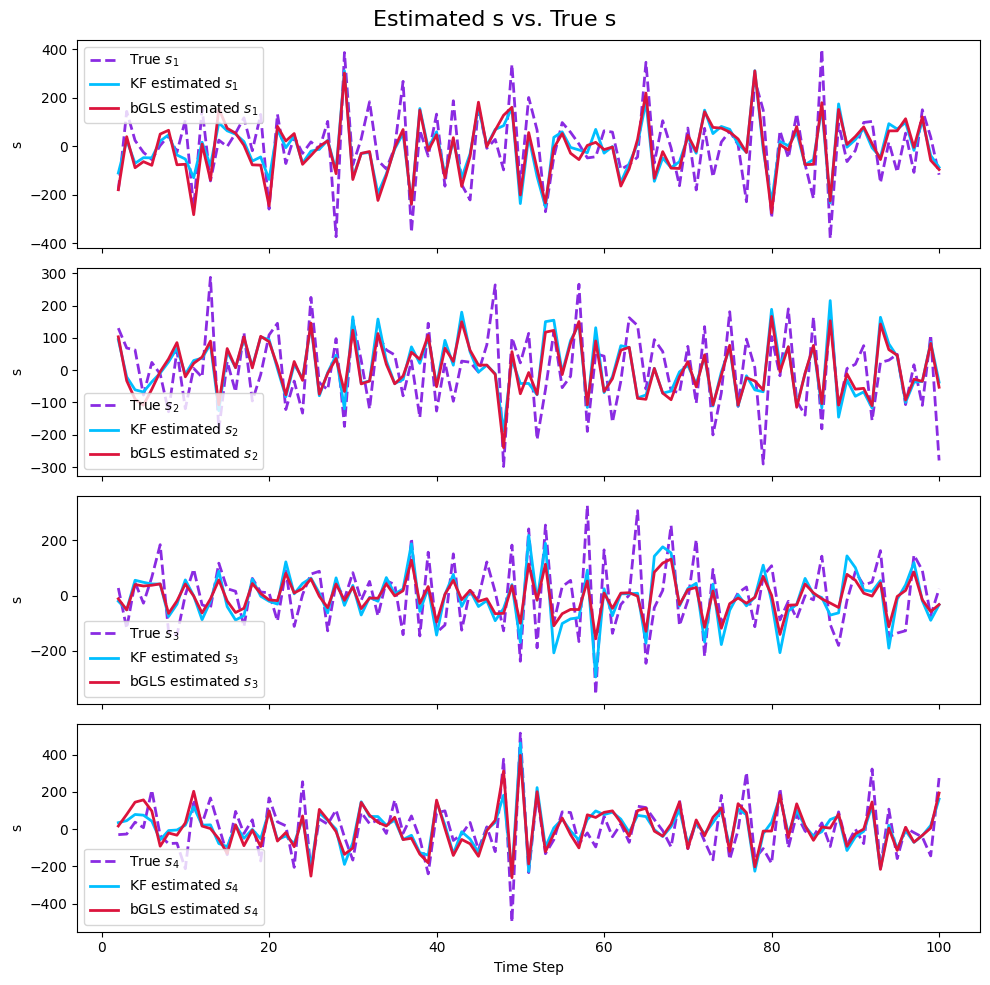

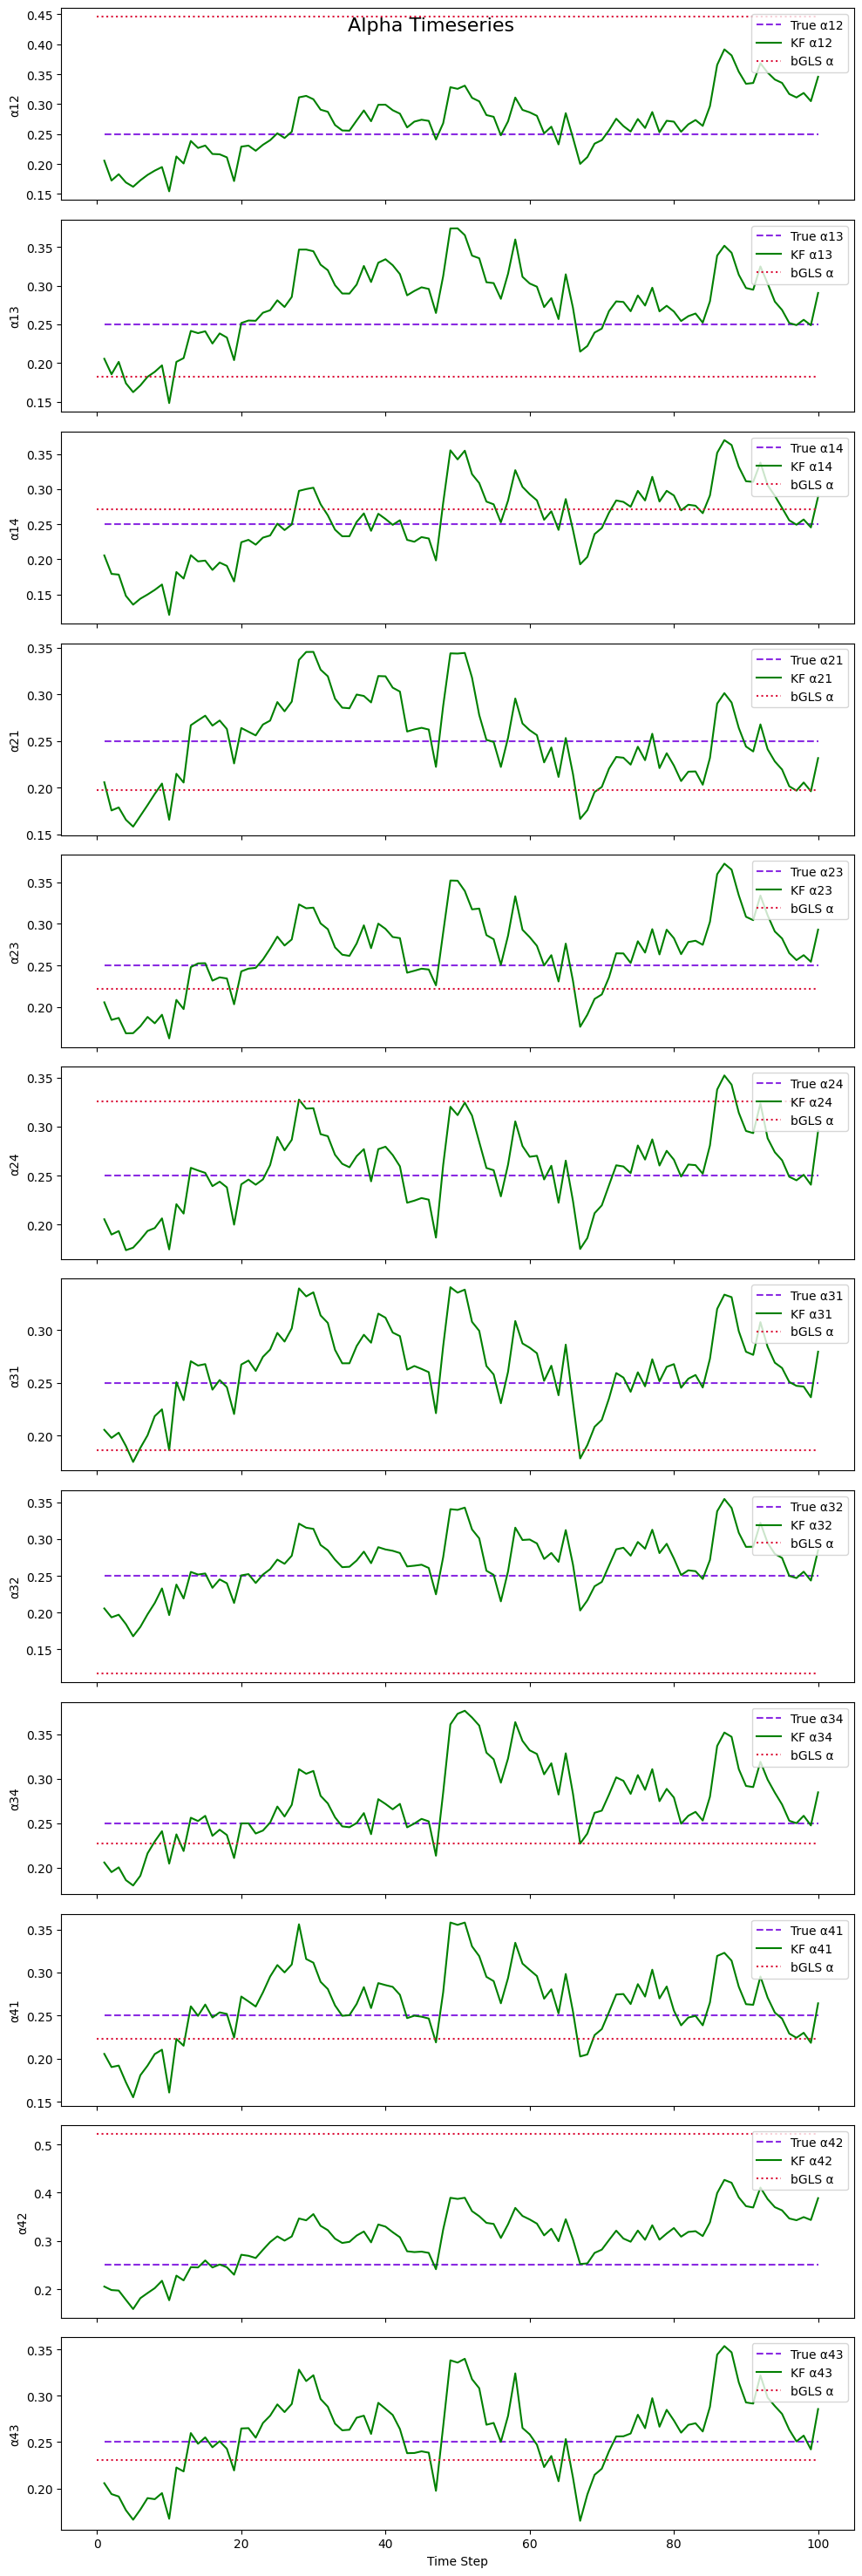

                 1       2       3       4
KF corr      0.738   0.618   0.685   0.763
KF var     103.640  97.754  92.239  95.151
bGLS corr    0.752   0.642   0.688   0.784
bGLS var   100.850  95.087  96.309  90.965
Running Static Alpha; Ideal Input | Iter 2/2


/tmp/ipython-input-3726657882.py:103: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(



 Average Metrics: Static Alpha; Ideal Input

Player  Corr (Optimised)  Std (Optimised)  Corr (Original)  Std (Original)  % improv. Corr  % improv. Std
     1             0.682          113.239            0.494         130.897            38.2           13.5
     2             0.603          100.786            0.415         140.240            45.3           28.1
     3             0.701           97.272            0.290         154.546           141.7           37.1
     4             0.726           97.420            0.420         147.945            72.5           34.2
Running Static Alpha; Realistic Input | Iter 1/2


/tmp/ipython-input-3726657882.py:103: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(


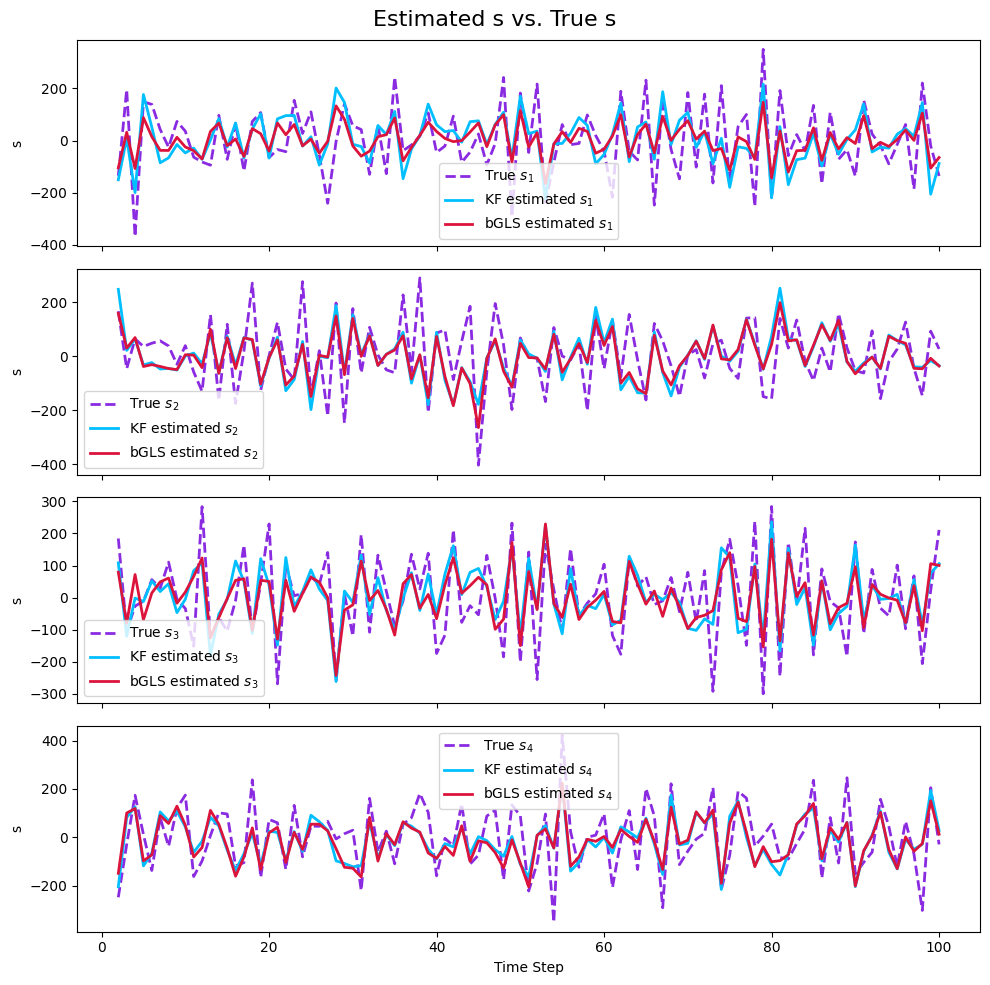

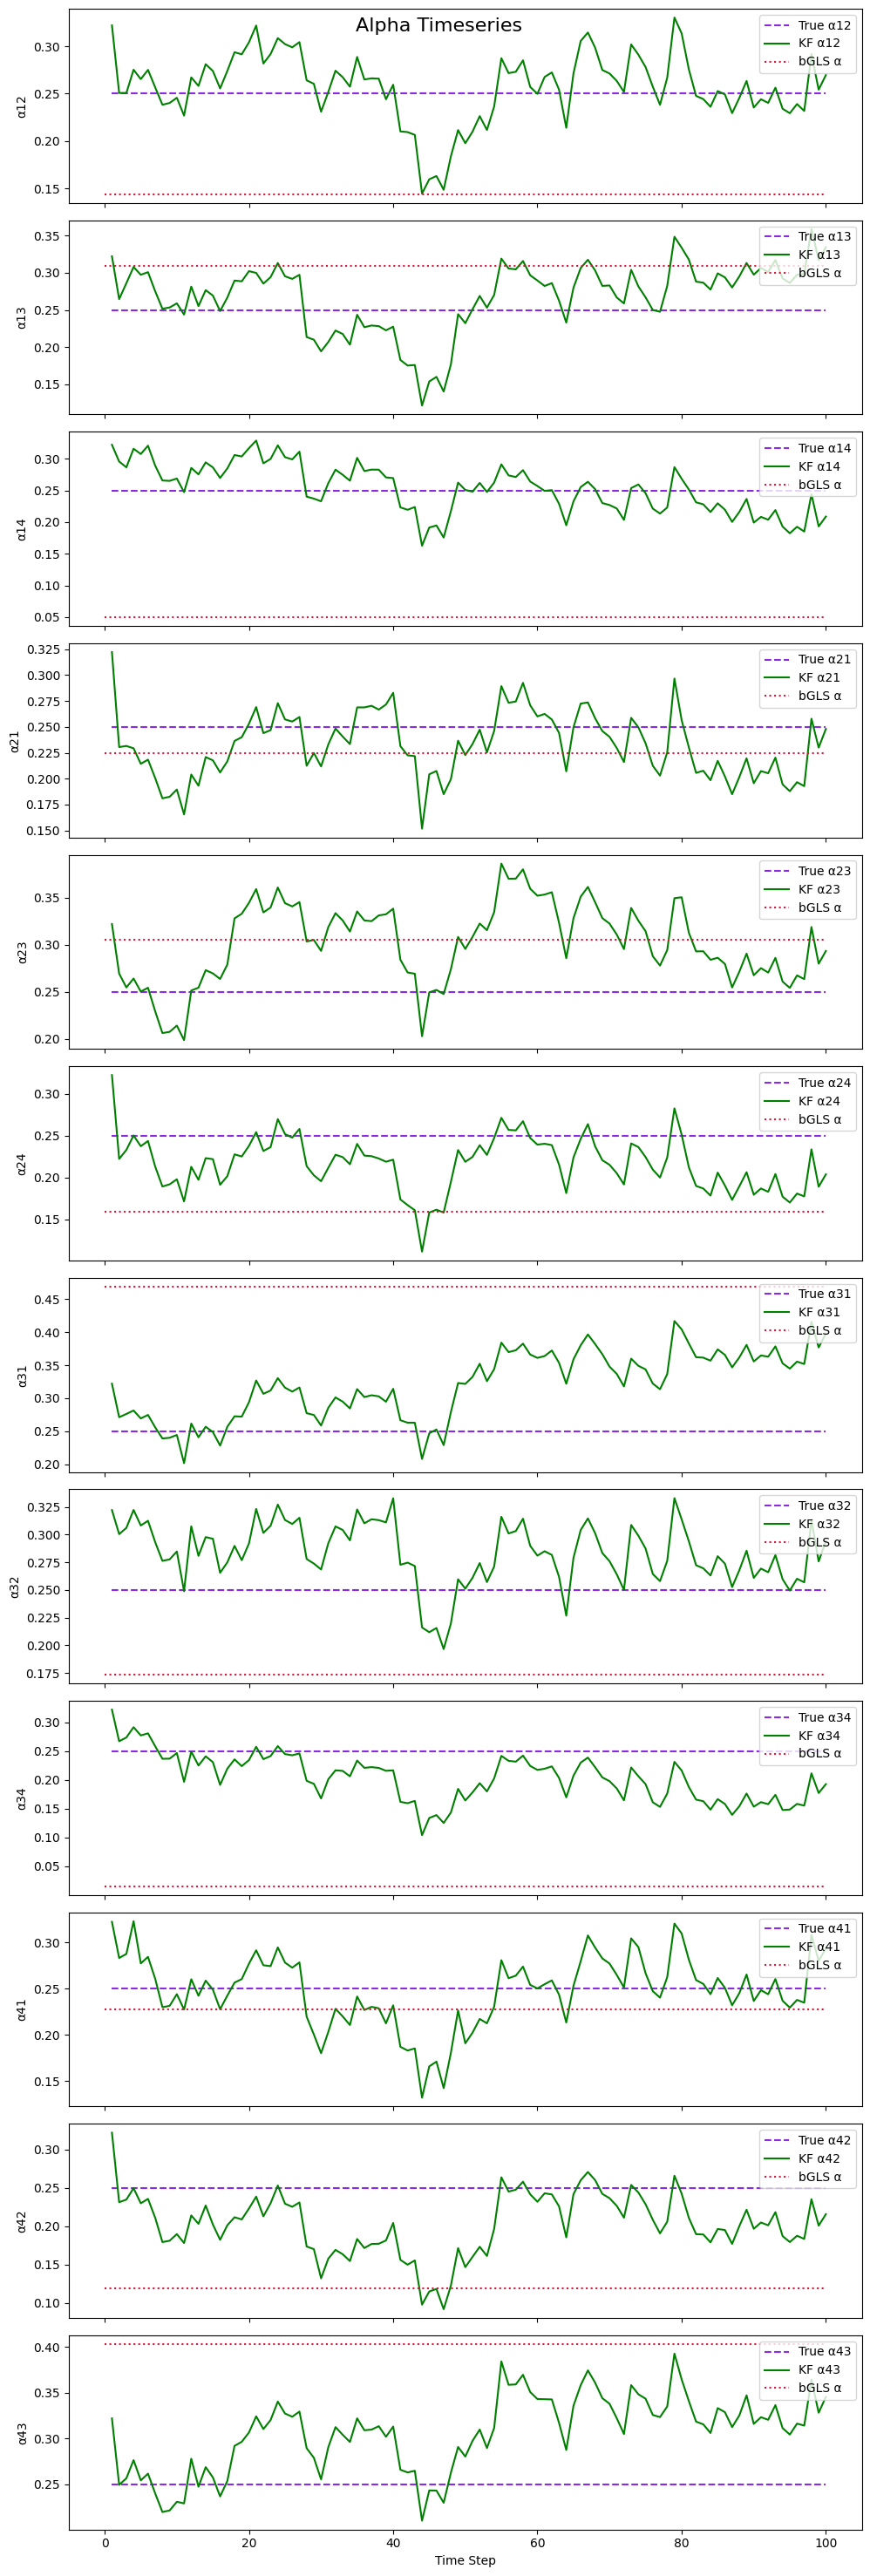

                 1        2       3        4
KF corr      0.652    0.598   0.753    0.682
KF var     103.117  101.293  90.397  101.754
bGLS corr    0.689    0.636   0.768    0.701
bGLS var   103.777   96.855  90.366   99.563
Running Static Alpha; Realistic Input | Iter 2/2


/tmp/ipython-input-3726657882.py:103: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(



 Average Metrics: Static Alpha; Realistic Input

Player  Corr (Optimised)  Std (Optimised)  Corr (Original)  Std (Original)  % improv. Corr  % improv. Std
     1             0.606          109.508            0.432         143.987            40.0           23.9
     2             0.572           98.661            0.374         152.876            52.9           35.5
     3             0.744           94.450            0.356         131.534           109.3           28.2
     4             0.649          104.977            0.514         130.735            26.0           19.7
Running Dynamic Alpha; Ideal Input | Iter 1/2


/tmp/ipython-input-3726657882.py:103: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(


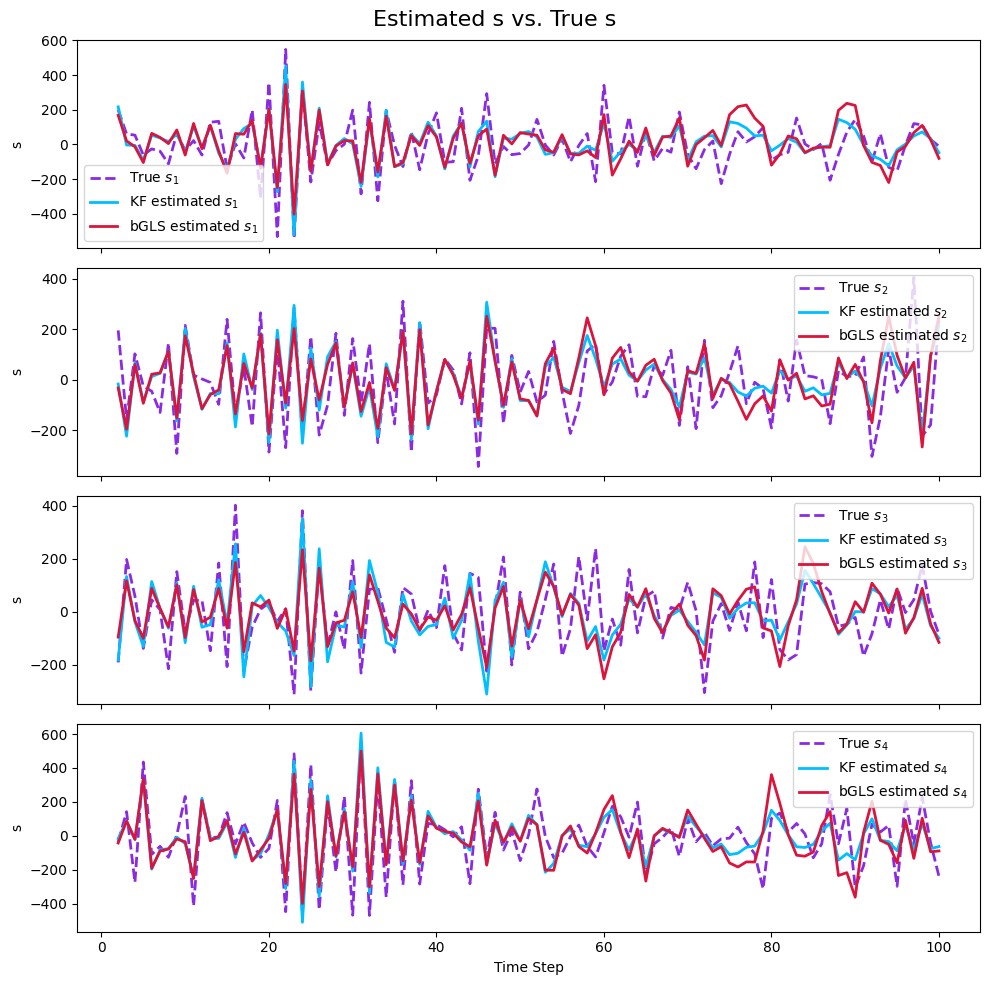

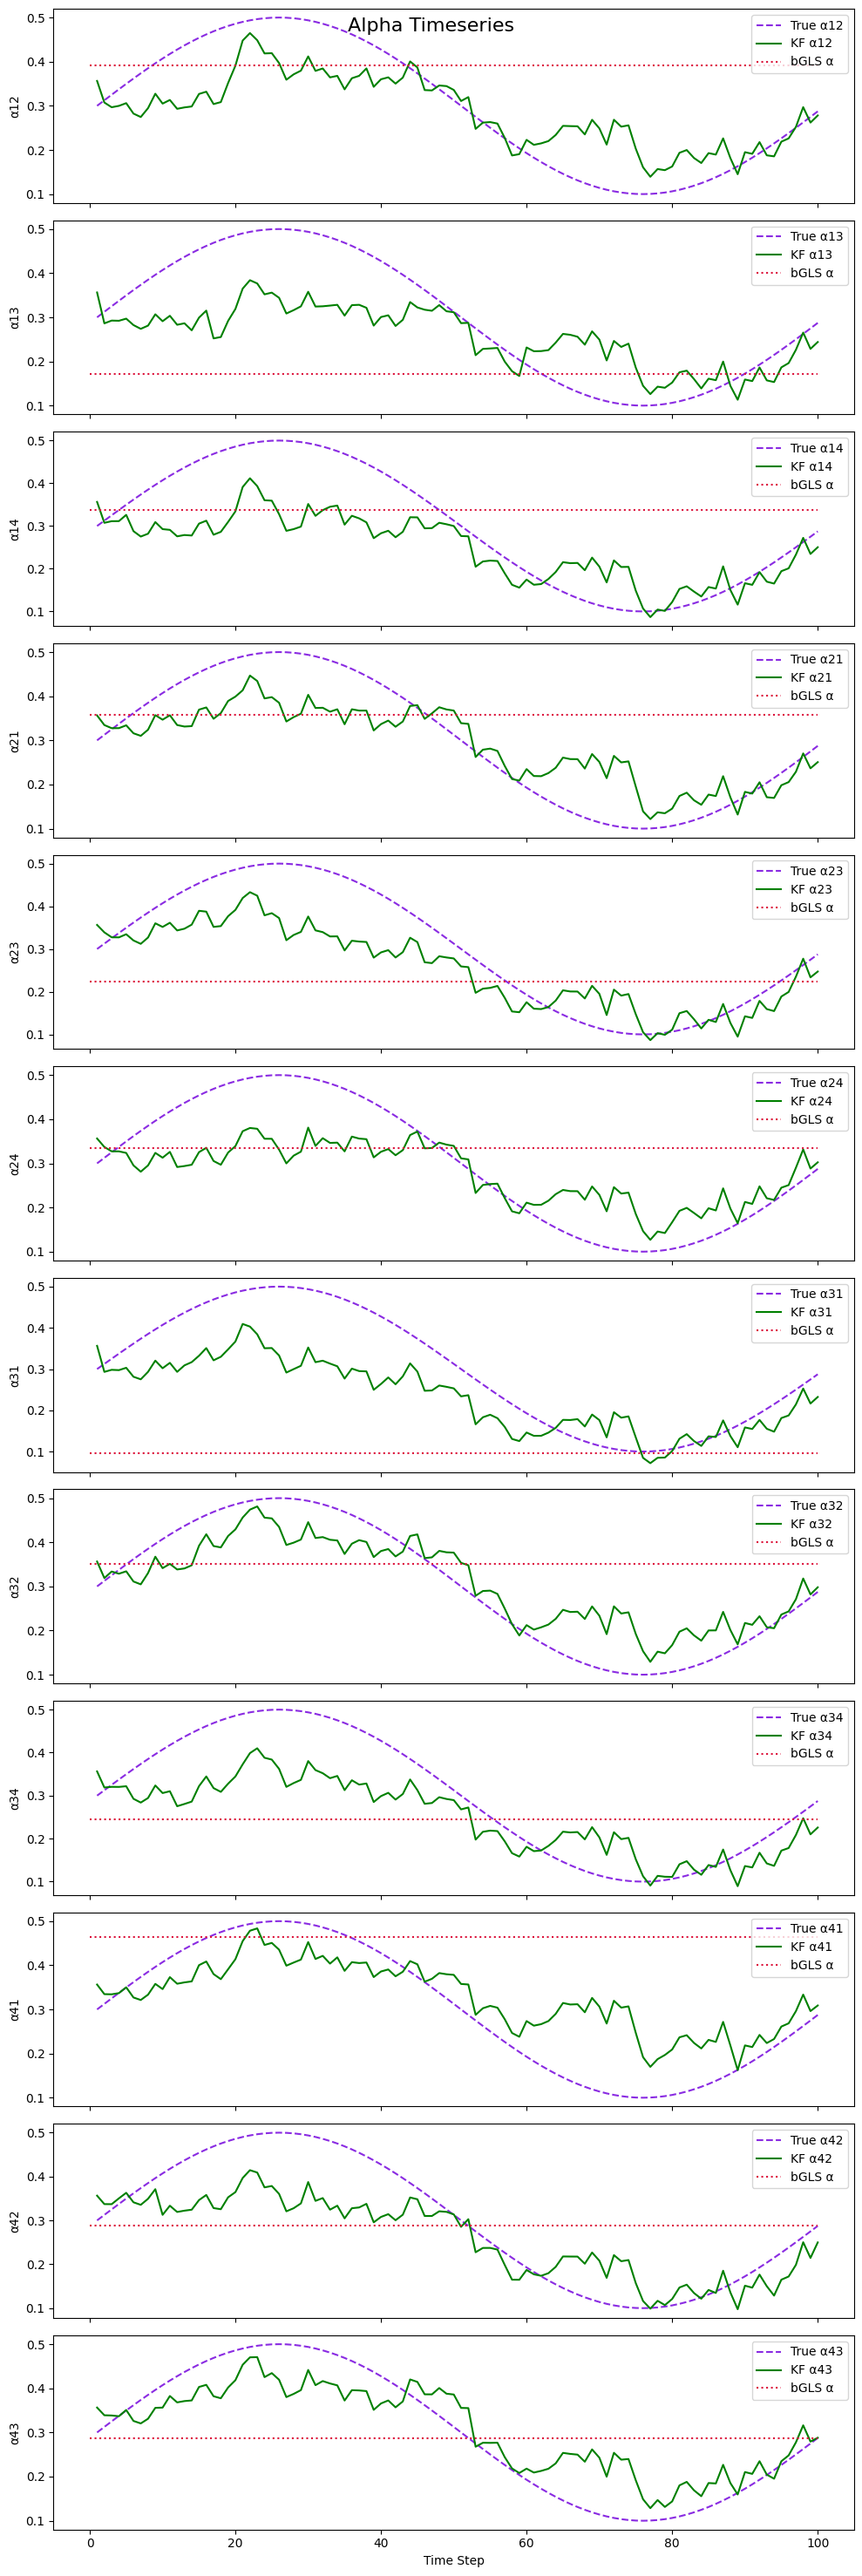

                 1        2        3        4
KF corr      0.806    0.761    0.742    0.846
KF var      97.597  101.494   94.386  112.369
bGLS corr    0.767    0.744    0.693    0.803
bGLS var   105.372  104.471  101.318  125.071
Running Dynamic Alpha; Ideal Input | Iter 2/2


/tmp/ipython-input-3726657882.py:103: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(



 Average Metrics: Dynamic Alpha; Ideal Input

Player  Corr (Optimised)  Std (Optimised)  Corr (Original)  Std (Original)  % improv. Corr  % improv. Std
     1             0.875          104.576            0.823         143.430             6.3           27.1
     2             0.852          106.141            0.797         139.816             7.0           24.1
     3             0.820          106.819            0.814         139.301             0.8           23.3
     4             0.888          119.620            0.914         133.760            -2.8           10.6
Running Dynamic Alpha; Realistic Input | Iter 1/2


/tmp/ipython-input-3726657882.py:103: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(


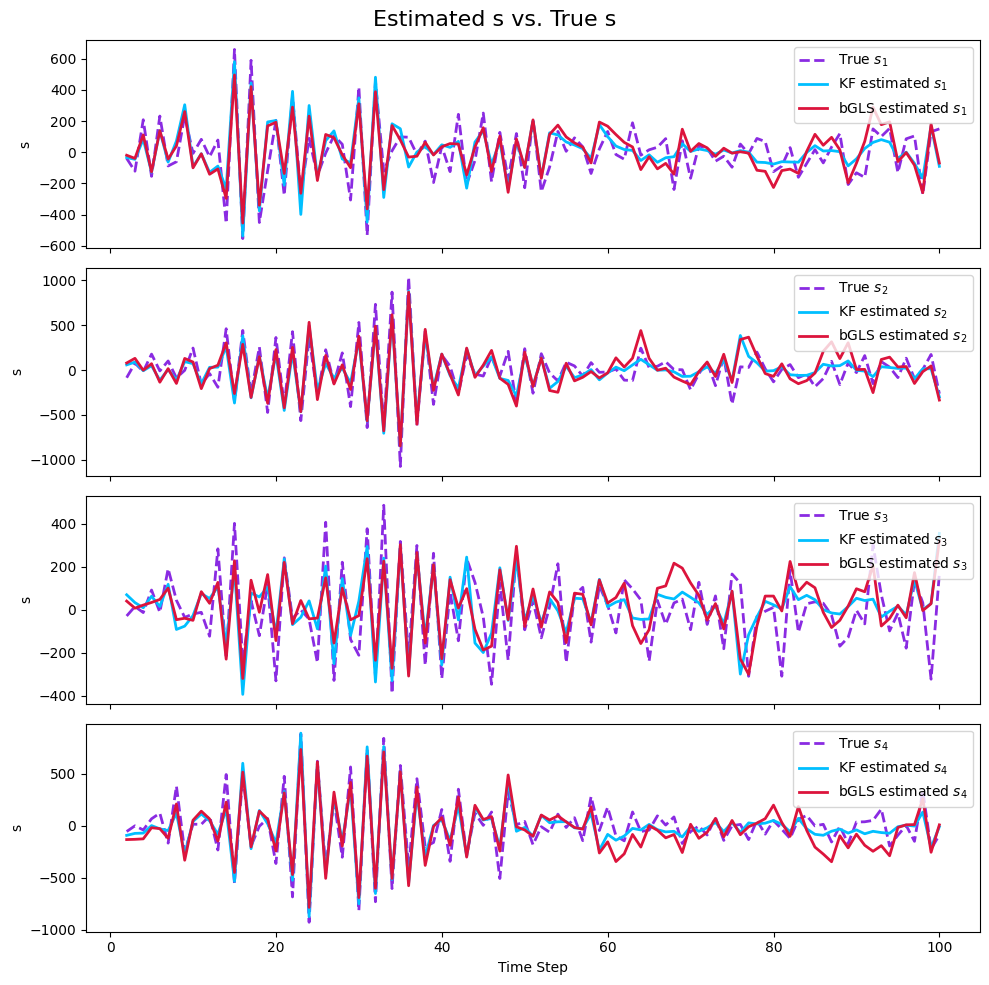

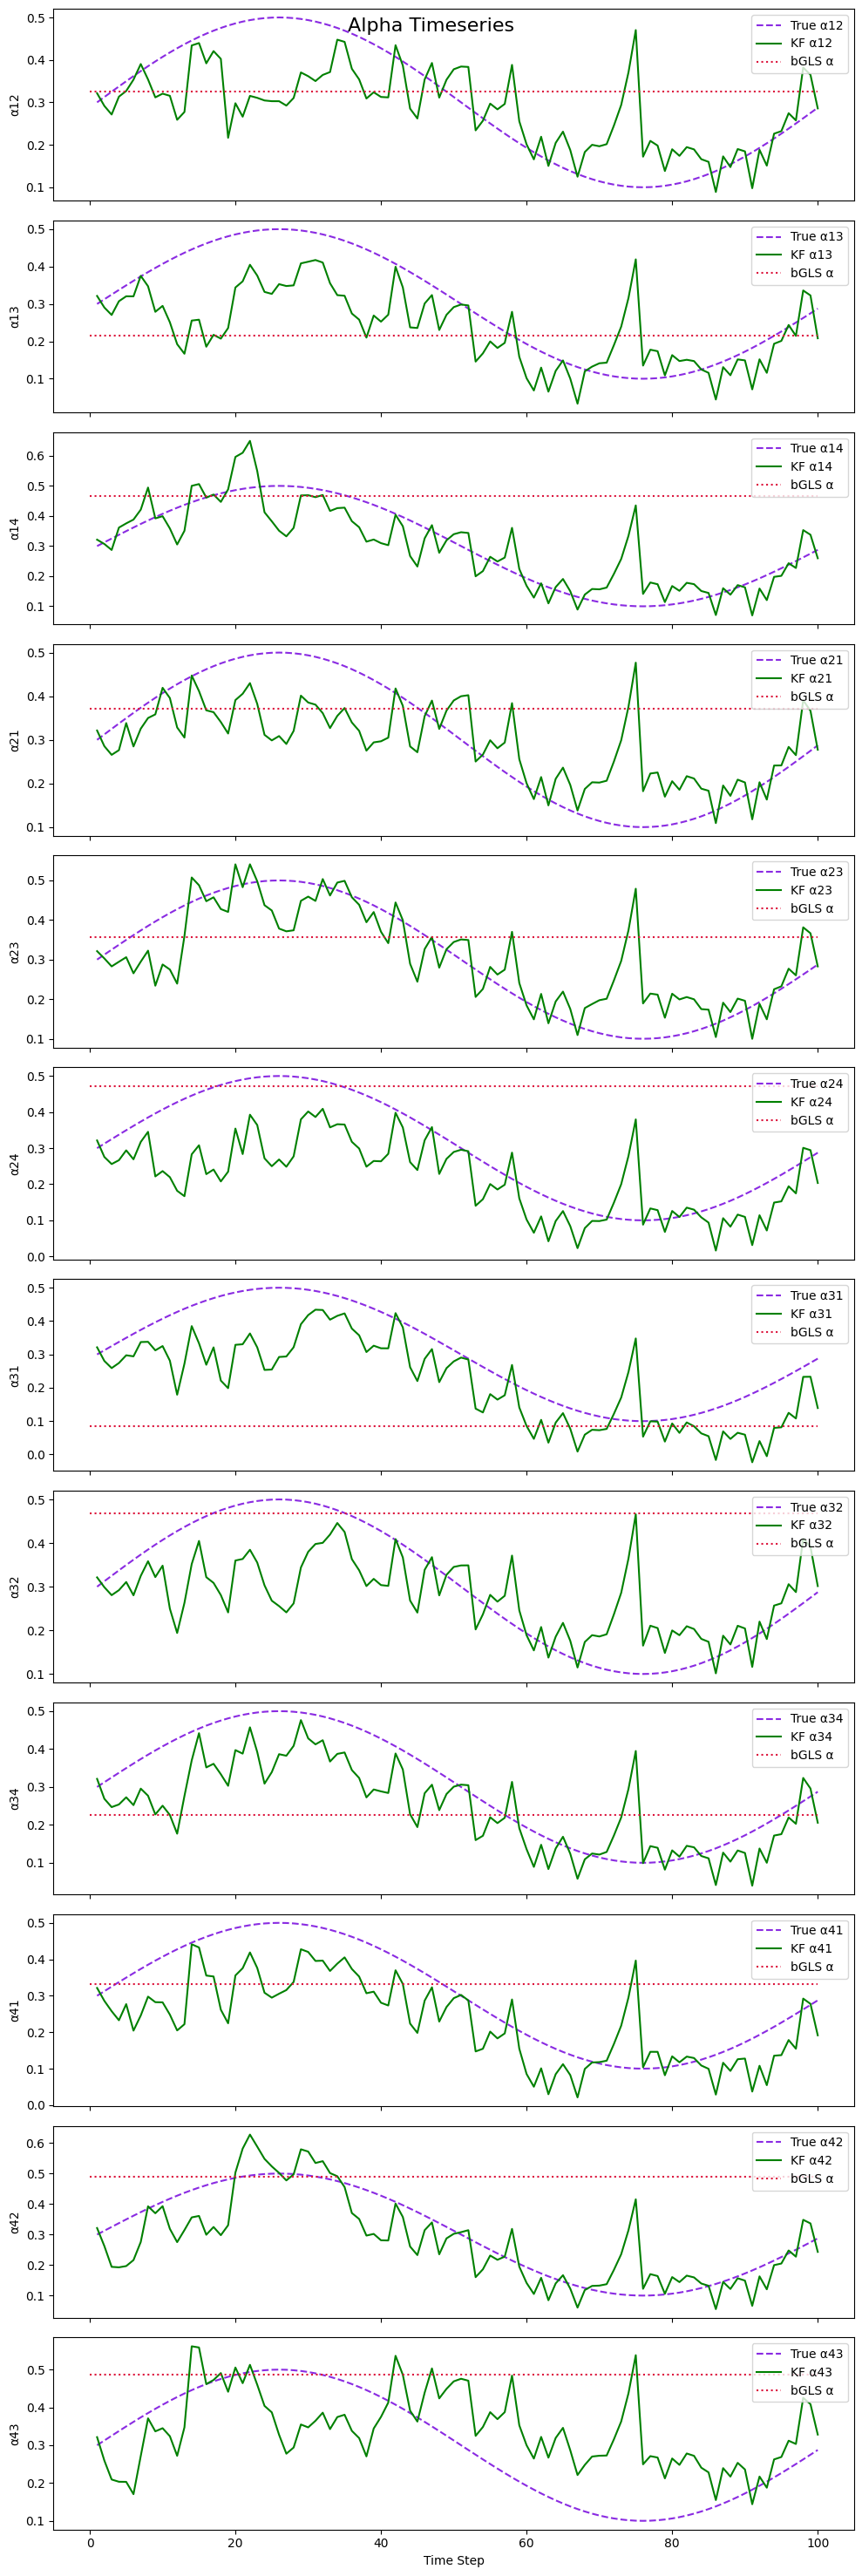

                 1        2        3        4
KF corr      0.834    0.915    0.732    0.930
KF var     110.668  125.648  128.189  115.797
bGLS corr    0.830    0.891    0.750    0.907
bGLS var   111.720  136.115  124.368  131.431
Running Dynamic Alpha; Realistic Input | Iter 2/2


/tmp/ipython-input-3726657882.py:103: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(



 Average Metrics: Dynamic Alpha; Realistic Input

Player  Corr (Optimised)  Std (Optimised)  Corr (Original)  Std (Original)  % improv. Corr  % improv. Std
     1             0.856          101.406            0.820         129.466             4.3           21.7
     2             0.922          121.584            0.810         133.192            13.9            8.7
     3             0.811          118.763            0.849         130.486            -4.5            9.0
     4             0.935          105.786            0.906         137.566             3.3           23.1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

# run KF with init params (not optimised)
def run_kf_with_initial_params(s_win, s_true, A, K, n_alpha, w, players):
    Sigma_v = np.diag([40.0] * K)
    Sigma_alpha = np.diag([0.3] * n_alpha)
    alpha_KF_init = np.array([1 / K] * n_alpha)
    sigma_w = 1e-1

    _, _, s_hat, *_ = KF_ensemble(
        s=s_win,
        A=A,
        Sigma_v_init=Sigma_v,
        Sigma_w=sigma_w,
        alpha_KF_init=alpha_KF_init,
        Sigma_alpha_init=Sigma_alpha,
        w=w
    )
    return metrics_ensemble(s_hat, s_true)


# single expt
def run_single_experiment(K, N, sigma_v_true, alpha_type, ideal, optimize_flags, w, plot=True, optimize=True):
    players = [str(k) for k in range(1, K + 1)]
    pairs = [str(i) + str(j) for i in players for j in players if i != j]
    n_alpha = len(pairs)

    if alpha_type == "static":
        alpha_val = 0.25
        alpha = {f"{i}{j}": [np.nan] + N * [alpha_val] for i in players for j in players if i != j}
    elif alpha_type == "dynamic":
        alpha = {f"{i}{j}": [np.nan] + [0.3 + 0.2 * np.sin(2 * np.pi * n / N) for n in range(N)]
                 for i in players for j in players if i != j}

    # generate data
    Tmkp = {k: [np.nan] + N * [500] for k in players}
    sigma_v_dict = {k: sigma_v_true for k in players}
    s_true, s_win, r, A, t, T = generate_ensemble_data(N, Tmkp, alpha, sigma_v_dict, w)
    s_input = s_true if ideal else s_win

    s_win_values = np.concatenate([s_win[p][~np.isnan(s_win[p])] for p in players])
    s_v_init = np.nanstd(s_win_values)
    s_alpha_init = 0.3
    alpha_init = 1 / K
    s_w_init = 1e-1

    def get_initial_params():
        params = []
        bounds = []
        if optimize_flags["sigma_w"]:
            params.append(s_w_init)
            bounds.append((1e-4, 1e2))
        if optimize_flags["sigma_v"]:
            params.append(s_v_init)
            bounds.append((1.0, 1e3))
        if optimize_flags["sigma_alpha"]:
            params.append(s_alpha_init)
            bounds.append((1e-3, 0.5))
        if optimize_flags["alpha_KF_init"]:
            params.append(alpha_init)
            bounds.append((0.0, 1.0))
        return np.array(params), bounds

    def loss_function(params):
        idx = 0
        try:
            sigma_w = params[idx] if optimize_flags["sigma_w"] else 1e-1
            idx += int(optimize_flags["sigma_w"])
            sigma_v = params[idx] if optimize_flags["sigma_v"] else 40.0
            Sigma_v = np.diag([sigma_v] * K)
            idx += int(optimize_flags["sigma_v"])
            sigma_alpha = params[idx] if optimize_flags["sigma_alpha"] else 0.3
            Sigma_alpha = np.diag([sigma_alpha] * n_alpha)
            idx += int(optimize_flags["sigma_alpha"])
            alpha_KF_val = params[idx] if optimize_flags["alpha_KF_init"] else 1 / K
            alpha_KF_init = np.array([alpha_KF_val] * n_alpha)

            _, _, s_hat, *_ = KF_ensemble(
                s=s_input,
                A=A,
                Sigma_v_init=Sigma_v,
                Sigma_w=sigma_w,
                alpha_KF_init=alpha_KF_init,
                Sigma_alpha_init=Sigma_alpha,
                w=w
            )
            s_hat_matrix = np.array([s_hat[p] for p in players])
            s_true_matrix = np.array([s_true[p] for p in players])
            valid_mask = ~np.isnan(s_hat_matrix) & ~np.isnan(s_true_matrix)
            if not np.any(valid_mask):
                return 1e6
            mse = np.mean((s_hat_matrix[valid_mask] - s_true_matrix[valid_mask]) ** 2)
            return mse
        except Exception as e:
            print(f"Loss function error: {e}")
            return 1e6

    if optimize:
        initial_params, bounds = get_initial_params()
        result = minimize(
            fun=loss_function,
            x0=initial_params,
            bounds=bounds,
            method='L-BFGS-B',
            options={"disp": False, "maxiter": 300}
        )

        # re-run KF with opt
        idx = 0
        sigma_w = result.x[idx] if optimize_flags["sigma_w"] else 1e-1
        idx += int(optimize_flags["sigma_w"])
        sigma_v = result.x[idx] if optimize_flags["sigma_v"] else 40.0
        Sigma_v = np.diag([sigma_v] * K)
        idx += int(optimize_flags["sigma_v"])
        sigma_alpha = result.x[idx] if optimize_flags["sigma_alpha"] else 0.3
        Sigma_alpha = np.diag([sigma_alpha] * n_alpha)
        idx += int(optimize_flags["sigma_alpha"])
        alpha_KF_val = result.x[idx] if optimize_flags["alpha_KF_init"] else 1 / K
        alpha_KF_init = np.array([alpha_KF_val] * n_alpha)
    else:
        # use og
        sigma_w = 1e-1
        Sigma_v = np.diag([40.0] * K)
        Sigma_alpha = np.diag([0.3] * n_alpha)
        alpha_KF_init = np.array([1 / K] * n_alpha)

    # run KF
    _, _, s_hat, _, alpha_hat, *_ = KF_ensemble(
        s=s_win,
        A=A,
        Sigma_v_init=Sigma_v,
        Sigma_w=sigma_w,
        alpha_KF_init=alpha_KF_init,
        Sigma_alpha_init=Sigma_alpha,
        w=w
    )


    # run bGLS for alpha and s timeseries
    # o_rm = np.array([s_true[p] for p in players]).T   # onset matrix
    alpha_bgls, _, _ = bGLS_ensemble(np.array(list(t.values())).T[1:, ])
    s_bgls = s_from_bGLS_ensemble(alpha_bgls, A)

    # plot s true vs s KF vs s bGLS
    if plot:
        met = pd.concat([pd.DataFrame(metrics_ensemble(s_hat, s_true)), pd.DataFrame(metrics_ensemble(s_bgls, s_true))], axis = 0)
        met.index = ['KF corr', 'KF var', 'bGLS corr', 'bGLS var']
        fig, axs = plt.subplots(K, 1, figsize=(10, 2.5 * K), sharex=True)
        fig.suptitle("Estimated s vs. True s", fontsize=16)
        for i, player in enumerate(players):
            axs[i].plot(s_true[player], color = 'blueviolet', label=f"True $s_{{{player}}}$", linestyle='--', linewidth=2)
            axs[i].plot(s_hat[player], color = 'deepskyblue', label=f"KF estimated $s_{{{player}}}$", linewidth=2)
            axs[i].plot(s_bgls[player], color = 'crimson', label=f"bGLS estimated $s_{{{player}}}$", linewidth=2)
            axs[i].legend()
            axs[i].set_ylabel("s")
        axs[-1].set_xlabel("Time Step")
        plt.tight_layout()
        plt.show()

        # plot trajectories
        fig, axs = plt.subplots(len(pairs), 1, figsize=(10, 2.5 * len(pairs)), sharex=True)
        fig.suptitle("Alpha Timeseries", fontsize=16)
        for idx, pair in enumerate(pairs):
            axs[idx].plot(alpha[pair], label=f"True α{pair}", color="blueviolet", linestyle="--")
            axs[idx].plot(alpha_hat[pair], label=f"KF α{pair}", color="green")
            axs[idx].hlines(alpha_bgls[pair], xmin=0, xmax=N, color="crimson", linestyle=":", label="bGLS α")
            axs[idx].legend(loc="upper right")
            axs[idx].set_ylabel(f"α{pair}")
        axs[-1].set_xlabel("Time Step")
        plt.tight_layout()
        plt.show()

        print(met)

    return metrics_ensemble(s_hat, s_true)

# run multiple expts & average metrics
def run_multiple_experiments(n_runs, config, label="", plot_first=True):
    players = [str(k) for k in range(1, config['K'] + 1)]
    all_metrics_opt = []
    all_metrics_init = []

    for i in range(n_runs):
        print(f"Running {label} | Iter {i+1}/{n_runs}")
        plot = (i == 0 and plot_first)

        m_opt = run_single_experiment(**config, plot=plot, optimize=True)
        all_metrics_opt.append(m_opt)

        m_init = run_single_experiment(**config, plot=False, optimize=False)
        all_metrics_init.append(m_init)

    def avg_metrics(metric_list):
        result = {}
        for p in players:
            corr_vals = [m[p]['corr'] for m in metric_list]
            std_vals = [m[p]['std'] for m in metric_list]
            result[p] = {
                'corr': np.mean(corr_vals),
                'std': np.mean(std_vals)
            }
        return result

    avg_opt = avg_metrics(all_metrics_opt)
    avg_init = avg_metrics(all_metrics_init)

    data = []
    for p in players:
        corr_opt = avg_opt[p]['corr']
        std_opt = avg_opt[p]['std']
        corr_init = avg_init[p]['corr']
        std_init = avg_init[p]['std']

        corr_improvement = 100 * (corr_opt - corr_init) / abs(corr_init)
        std_improvement = 100 * (std_init - std_opt) / abs(std_init)

        data.append([
            p,
            round(corr_opt, 3),
            round(std_opt, 3),
            round(corr_init, 3),
            round(std_init, 3),
            round(corr_improvement, 1),
            round(std_improvement, 1)
        ])

    df = pd.DataFrame(data, columns=[
        "Player",
        "Corr (Optimised)", "Std (Optimised)",
        "Corr (Original)", "Std (Original)",
        "% improv. Corr", "% improv. Std"
    ])

    print(f"\n Average Metrics: {label}\n")
    print(df.to_string(index=False))
    return df


# run examples
optimize_flags = {
    "sigma_w": True,
    "sigma_v": True,
    "sigma_alpha": True,
    "alpha_KF_init": True
}

sigma_v_true = 100
configs = [
    {"K": 4, "N": 100, "sigma_v_true": sigma_v_true, "alpha_type": "static", "ideal": True, "optimize_flags": optimize_flags, "w": 5},
    {"K": 4, "N": 100, "sigma_v_true": sigma_v_true, "alpha_type": "static", "ideal": False, "optimize_flags": optimize_flags, "w": 5},
    {"K": 4, "N": 100, "sigma_v_true": sigma_v_true, "alpha_type": "dynamic", "ideal": True, "optimize_flags": optimize_flags, "w": 5},
    {"K": 4, "N": 100, "sigma_v_true": sigma_v_true, "alpha_type": "dynamic", "ideal": False, "optimize_flags": optimize_flags, "w": 5},
]

titles = [
    "Static Alpha; Ideal Input",
    "Static Alpha; Realistic Input",
    "Dynamic Alpha; Ideal Input",
    "Dynamic Alpha; Realistic Input"
]

all_results = []

# change no. of iterations - KEPT AT 2 FOR TESTING
for cfg, title in zip(configs, titles):
    df = run_multiple_experiments(n_runs=2, config=cfg, label=title)  # ← Change n_runs here
    all_results.append((title, df))
